In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


# titlesize = 24
# labelsize = 22
# legendsize = 22
# xticksize = 18
# yticksize = xticksize

# plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
# plt.rcParams['legend.handletextpad'] = 0.5
# plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
# plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
# plt.rcParams['font.size'] = 12
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['axes.labelsize'] = labelsize
# plt.rcParams['axes.titlesize'] = titlesize
# plt.rcParams['figure.figsize'] = (10, 8)

# plt.rc('xtick', labelsize=xticksize)
# plt.rc('ytick', labelsize=yticksize)
# plt.rc('legend', fontsize=legendsize)

# Ratio-метрики и линеаризация

Мы поговорим о различных способах построения метрик, сравним их плюсы и минусы, обсудим возможность применения тех или иных статистических критериев.

В фокусе нашего внимания будут:

- Пользовательские метрики

- Ratio-метрики

- Линеаризация для ratio-метрик

А так же обсудим применение бутстрепа и дельта-метода для указанных случаев.

### Генерация данных о сессиях пользователей

Будем генерировать пользователей со случайным количеством сессий от 3 до 9. У каждого пользователя будет своя средняя длина сессии, множество сессий пользователя будет генерироваться просто добавлением шума к средней длине сессии пользователя.

In [2]:
def get_session_duration(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: List[np.array], список массивов,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    def _user_sessions(mean):
        size = np.random.randint(3,10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    return [_user_sessions(mean) for mean in mean_durations]


посмотри как работает функция генерации данных

In [3]:
get_session_duration(5, effect=0, seed=None)

[array([77., 85., 85., 75.]),
 array([ 83.,  89.,  89.,  87., 108.,  86.,  87., 100.,  96.]),
 array([ 91., 123.,  99.]),
 array([66., 60., 89.]),
 array([123., 109., 124., 139., 125., 116.])]

# 1. AA-тест и распределение p-value

Корректно работающий тест дает равномерное распределение p-value для AA-теста.  Действительно, p-value показывает вероятность получить такое-же или большее значение статистики при справедливости нулевой гипотезы. Из этого автоматически следует выше написанное утверждение.

С помощью библиотеки [Seaborn](https://seaborn.pydata.org/index.html) мы построим визуальное отображение для эмпирических функций распределения p-value. Для этого нам понадобятся

[seaborn.histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html):
```
seaborn.histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, 
    discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, 
    shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, 
    cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
```

[seaborn.ecdfplot](https://seaborn.pydata.org/generated/seaborn.ecdfplot.html):
```
seaborn.ecdfplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='proportion', complementary=False, 
    palette=None, hue_order=None, hue_norm=None, log_scale=None, legend=True, ax=None, **kwargs)
```

In [4]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

Проверим наши рассуждения на примере нормального распределения:

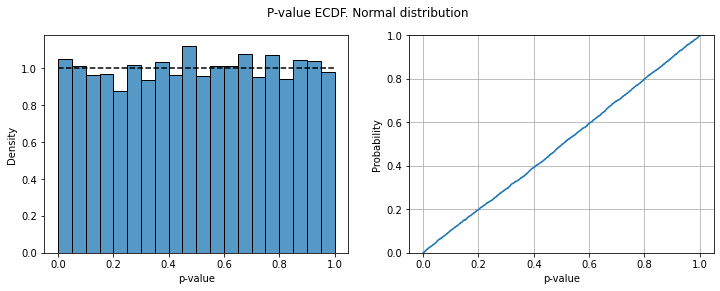

In [5]:
def get_pvalue_samples(a_sample_generator, b_sample_generator, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        _, p = stats.ttest_ind(a_sample_generator(), b_sample_generator())
        pvalues.append(p)
    return pvalues

pvalues = get_pvalue_samples(
    a_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    b_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    size=5000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

Наши ожидания выполнены. Мы видим распределение близкое к равномерному.

# 2. Проблема зависимых случайных величин. Тест Стьюдента по сессиям

Посмотрим что произойдет с тестом при наивном применении. Когда мы в качестве случайных величин возьмем длины сессий пользователей в экспериментальной и контрольной группах.

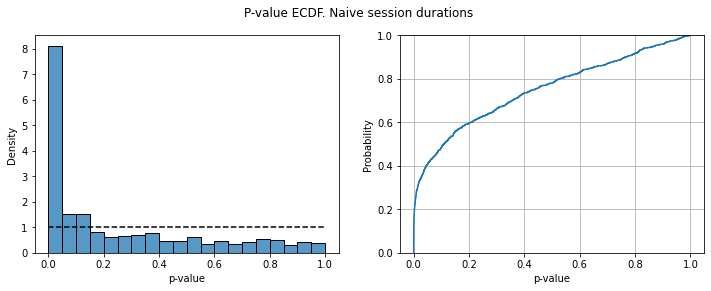

In [6]:
def check_ttest_naive(a, b):
    """Проверка гипотезы с помощью наивного среднего по длинам сессий.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_naive = np.concatenate(a)
    b_naive = np.concatenate(b)
    _, pvalue = stats.ttest_ind(a_naive, b_naive)
    delta = b_naive.mean() - a_naive.mean()
    return pvalue, delta

def naive_session_durations(size=100, effect=0):
    def _durations():
        durations = get_session_duration(size=size, effect=effect)
        return np.concatenate(durations)
    return _durations

pvalues = get_pvalue_samples(
    a_sample_generator=naive_session_durations(size=100, effect=0),
    b_sample_generator=naive_session_durations(size=100, effect=0),
    size=1000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Naive session durations')

Мы видим, что полученное распределение сильно неравномерное. Это говорит о неверно сконструированном тесте. 

pvalue < 0.05 примерно в 40% случаев, то есть в 40% случаев мы отклонили нулевую гипотезу, когда она была верна.

Всё это связано с тем, что длины сессий не будут независимыми. Для каждого пользователя вообще говоря будет свое распределение. И неравенство в выборе приводит к таким плачевным результатам.

# 3. Среднее по пользователям

Не всегда, но очень часто, мы можем предполагать независимость действий отдельных пользователей. Поэтому и статистики для пользователей должны быть независимыми.

Посмотрим на распределение p-value для user average. А так же выясним сохраняется ли направленность метрики.


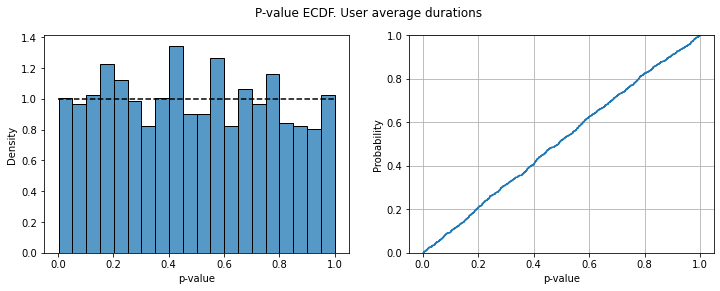

In [7]:
def check_ttest_avg(a, b):
    """Проверка гипотезы с помощью среднего по пользователям.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_avg = [t.mean() for t in a]
    b_avg = [t.mean() for t in b]
    _, pvalue = stats.ttest_ind(a_avg, b_avg)
    delta = np.mean(b_avg) - np.mean(a_avg)
    return pvalue, delta

def user_average_durations(size=100, effect=0):
    def _durations():
        durations = get_session_duration(size=size, effect=effect)
        return [t.mean() for t in durations]
    return _durations

pvalues = get_pvalue_samples(
    a_sample_generator=user_average_durations(size=100, effect=0),
    b_sample_generator=user_average_durations(size=100, effect=0),
    size=1000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. User average durations')

Сравним направленность метрик.

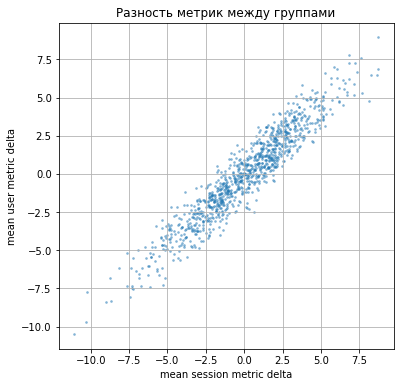

In [8]:
list_session_mean = []
list_user_avg_mean = []

def get_naive_mean_delta(a, b):
    return np.concatenate(b).mean() - np.concatenate(a).mean()

def get_user_avg_mean_delta(a, b):
    return np.mean([t.mean() for t in b]) - np.mean([t.mean() for t in a])

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    list_session_mean.append(get_naive_mean_delta(a, b))
    list_user_avg_mean.append(get_user_avg_mean_delta(a, b))

plt.figure(figsize=(6,6))
plt.scatter(list_session_mean, list_user_avg_mean, s=3, alpha=0.4)
plt.ylabel('mean user metric delta')
plt.xlabel('mean session metric delta')
plt.title('Разность метрик между группами')
plt.grid()
plt.show()

Видно, что есть точки в верхнем левом и в правом нижнем квадранте, для данных соответствующих итм точкам направленность метрики не сохраняется.

# 3. Бутстреп
Будем сэплировать пользователей из групп и считать разность ratio метрики.

In [9]:
def check_bootstrap(a, b, n=1000):
    """Проверка гипотезы с помощью бутстрепа по пользователям.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    n: int, кол-во итераций бутстрепа
    
    return: pvalue и точечную оценку.
    """
    len_a = len(a)
    len_b = len(b)
    # предобработаем данные
    # посчитаем заранее сумму длин сессий и их кол-во для каждого пользователя
    a_sum_count = np.zeros((len_a, 2))
    a_sum_count[:, 0] = np.array([np.sum(row) for row in a])
    a_sum_count[:, 1] = np.array([len(row) for row in a])
    b_sum_count = np.zeros((len_b, 2))
    b_sum_count[:, 0] = np.array([np.sum(row) for row in b])
    b_sum_count[:, 1] = np.array([len(row) for row in b])
    
    list_diff = []
    for _ in range(n):
        a_bootstrap_index = np.random.choice(np.arange(len_a), len_a)
        b_bootstrap_index = np.random.choice(np.arange(len_b), len_b)
        a_bootstrap = a_sum_count[a_bootstrap_index]
        b_bootstrap = b_sum_count[b_bootstrap_index]
        a_metric = a_bootstrap[:, 0].sum() / a_bootstrap[:, 1].sum()
        b_metric = b_bootstrap[:, 0].sum() / b_bootstrap[:, 1].sum()
        list_diff.append(b_metric - a_metric)
    delta = (
        b_sum_count[:, 0].sum() / b_sum_count[:, 1].sum()
        - a_sum_count[:, 0].sum() / a_sum_count[:, 1].sum()
    )
    std = np.std(list_diff)
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(delta / std)))
    return pvalue, delta

Проверим наличие у этого способа недостатков прошлых методов: неравномерность pvalue на aa-тесте и направленность.

In [10]:
# cell time = 1m16s

list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    pvalue, delta = check_bootstrap(a, b)
    list_real_delta.append(get_naive_mean_delta(a, b))
    list_delta.append(delta)
    list_pvalue.append(pvalue)

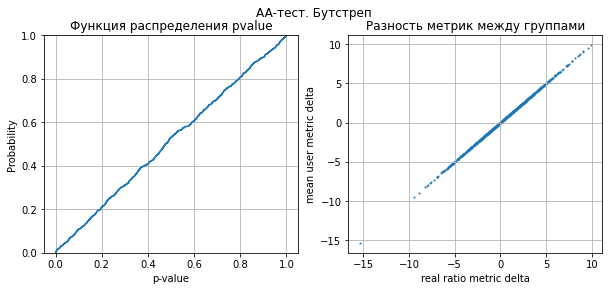

In [11]:
def plot_two_graphs(list_pvalue, list_delta, list_real_delta, suptitle=None):
    """Строим распределение pvalue и граффик направленности.
  
    list_pvalue: pvalue метода
    list_delta: разность метрик между группами метода
    list_delta: разность изначальной ratio метрики между группами
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,4])

    if suptitle:
        plt.suptitle(suptitle)
    sns.ecdfplot(list_pvalue, ax=ax1)
    ax1.set_ylabel('Probability')
    ax1.set_xlabel('p-value')
    ax1.set_title('Функция распределения pvalue')
    ax1.grid()

    ax2.scatter(list_real_delta, list_delta, s=1)
    ax2.set_ylabel('mean user metric delta')
    ax2.set_xlabel('real ratio metric delta')
    ax2.set_title('Разность метрик между группами')
    ax2.grid()

    plt.show()

plot_two_graphs(list_pvalue, list_delta, list_real_delta, suptitle='AA-тест. Бутстреп')

pvalue распределено равномерно, направленность сохраняется.

Отметим, что время вычислений заметно увеличилась.

#### Проверим может ли этот тест ловить эффект.
Увеличим длину сессий в группе **b**.

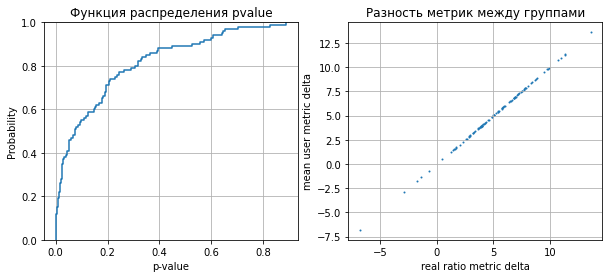

In [12]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(100)):
    a = get_session_duration(100)
    b = get_session_duration(100, effect=0.05)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_bootstrap(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

plot_two_graphs(list_pvalue, list_delta, list_real_delta)

Видно, что распределение pvalue сместилось ближе к нулю, то есть нулевая гипотеза стала чаще отвергаться.

# 4. Дельта метод
Реализуем дельта метод.

In [13]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта метод.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    dict_stats = {'a': {'data': a}, 'b': {'data': b}}
    for key, dict_ in dict_stats.items():
        data = dict_['data']
        dict_['x'] = np.array([np.sum(row) for row in data])
        dict_['y'] = np.array([len(row) for row in data])
        dict_['metric'] = np.sum(dict_['x']) / np.sum(dict_['y'])
        dict_['len'] = len(data)
        dict_['mean_x'] = np.mean(dict_['x'])
        dict_['mean_y'] = np.mean(dict_['y'])
        dict_['std_x'] = np.std(dict_['x'])
        dict_['std_y'] = np.std(dict_['y'])
        dict_['cov_xy'] = np.cov(dict_['x'], dict_['y'])[0, 1]
        dict_['var_metric'] = (
            (dict_['std_x'] ** 2) / (dict_['mean_y'] ** 2)
            + (dict_['mean_x'] ** 2) / (dict_['mean_y'] ** 4) * (dict_['std_y'] ** 2)
            - 2 * dict_['mean_x'] / (dict_['mean_y'] ** 3) * dict_['cov_xy']
        ) / dict_['len']
    var = dict_stats['b']['var_metric'] + dict_stats['a']['var_metric']
    delta = dict_stats['b']['metric'] - dict_stats['a']['metric']
    statistic = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(statistic))) * 2
    return pvalue, delta

Проведём проверки аналогичные бутстрепу


Эффекта нет


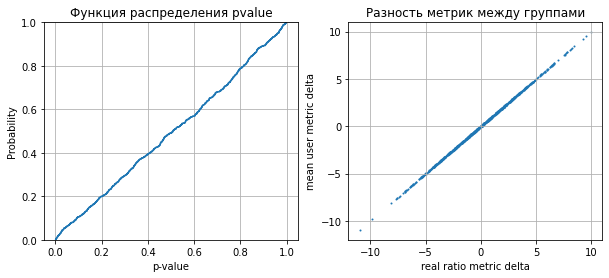

In [14]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_delta_method(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффекта нет')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)


Эффект есть


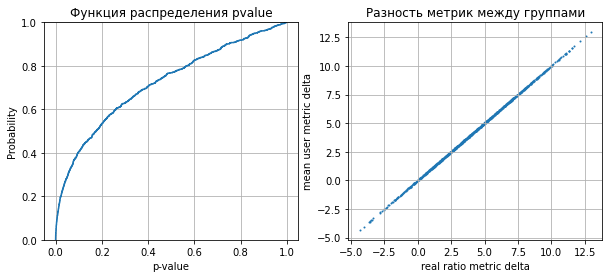

In [15]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100, 0.04)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_delta_method(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффект есть')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)

Получаем ожидаемые корректные результаты.

# 5. Линеаризация

In [16]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta


Эффекта нет


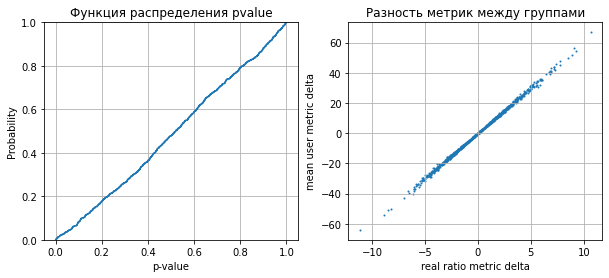

In [17]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_linearization(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффекта нет')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)


Эффект есть


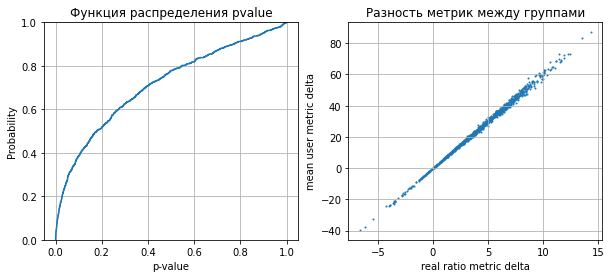

In [18]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100, 0.04)
    real_delta = np.concatenate(b).mean() - np.concatenate(a).mean()
    pvalue, delta = check_linearization(a, b)
    list_real_delta.append(real_delta)
    list_delta.append(delta)
    list_pvalue.append(pvalue)

print('Эффект есть')
plot_two_graphs(list_pvalue, list_delta, list_real_delta)

Получаем ожидаемые корректные результаты.

# 6. Итого
Посмотрим на методы вместе. Будем генерировать данные и считать значения приращения метрик и pvalue всеми способами, и отобразим полученные результаты на графиках.

In [19]:
dict_check = {
    'bootstrap': check_bootstrap,
    'naive': check_ttest_naive,
    'avg': check_ttest_avg,
    'delta': check_delta_method,
    'linearization': check_linearization
}

res_dict = {key: {'pvalue': [], 'delta': []} for key in dict_check}
for _ in tqdm(range(200)):
    a = get_session_duration(100)
    b = get_session_duration(100, effect=np.random.choice([0, -0.05, 0.05]))
    for method_name, method_func in dict_check.items():
        pvalue, delta = method_func(a, b)
        res_dict[method_name]['pvalue'].append(pvalue)
        res_dict[method_name]['delta'].append(delta)

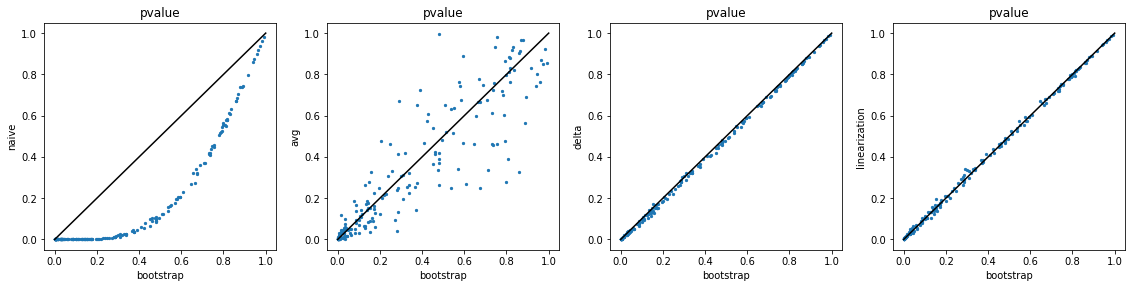

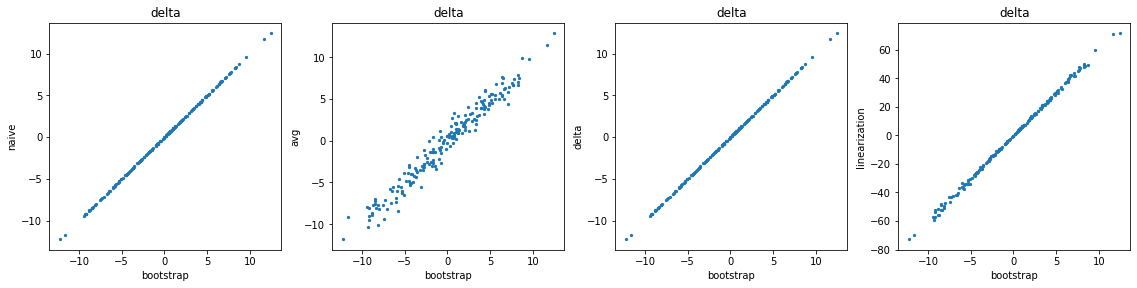

In [20]:
pvalues_bootstrap = res_dict['bootstrap']['pvalue']
deltas_bootstrap = res_dict['bootstrap']['delta']

for data_type in ['pvalue', 'delta']:
    fig, axes = plt.subplots(1, len(res_dict) - 1, figsize=[16, 4])
    fig.tight_layout(pad=2)
    plot_id = 0
    for key in res_dict:
        if key == 'bootstrap':
            continue
        axes[plot_id].scatter(res_dict['bootstrap'][data_type], res_dict[key][data_type], s=5)
        if data_type == 'pvalue':
            axes[plot_id].plot([0, 1], [0, 1], 'k')
        axes[plot_id].set_ylabel(key)
        axes[plot_id].set_xlabel('bootstrap')
        axes[plot_id].set_title(data_type)
        plot_id += 1
    plt.show()
        
    

В верхнем ряду графики для pvalue, в нижнем для разности метрик.

По оси абсцисс везде бутстреп, по оси ординат остальные методы.

Видно, что первые два метода отличаются от остальных и дают некорректные pvalue.

Результаты бустрепа, дельта метода и метода линеаризации очень похожи.

Бутстреп плох сложностью вычислений, которые занимают много времени.

Преимущестов линеаризации над дельта методом в наличии пользовательской метрики, давайте придумаем пример, где это может дать преимущество.

# 7. Delta method VS Linearization
Нам понадобятся данные о пользовательских сессия до пилота. Пусть там будет случайно кол-во сессий от 3 до 9, но то же среднее значение продолжительности сессии.

In [21]:
def get_session_duration_with_prepilot(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: (List[np.array], List[np.array]), пара списков с массивами до пилота и во время пилота,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    if seed:
        np.random.seed(seed)
    mean_durations = np.random.normal(100, 20, size)
    count_sessions = np.random.randint(3, 10, size)
    count_sessions_before = np.random.randint(3, 10, size)
    data = []
    data_before = []
    zip_data = zip(mean_durations, count_sessions, count_sessions_before)
    for mean_duration, count_session, count_session_before in zip_data:
        data.append((np.random.normal(0, 10, count_session) + mean_duration * (1 + effect)).round())
        data_before.append((np.random.normal(0, 10, count_session_before) + mean_duration).round())
    return data_before, data

In [22]:
get_session_duration_with_prepilot(3, 0.1)

([array([109., 109.,  86.,  82., 101.]),
  array([ 76.,  82.,  89.,  98.,  82., 119.,  99.,  85.]),
  array([110., 116., 116., 103., 102., 103.,  90., 105.])],
 [array([ 82.,  93., 108.]),
  array([103., 105.,  92., 119., 116.]),
  array([106., 116., 111., 110., 117., 115., 112., 101.,  95.])])

Сгенерируем данные для пилотной и контрольной групп

In [23]:
size = 10000

np.random.seed(23)

data_pilot_before, data_pilot = get_session_duration_with_prepilot(size, 0.01)
data_control_before, data_control = get_session_duration_with_prepilot(size)

Посчитаем pvalue с помощью дельта метода и метода линеаризации

In [24]:
pvalue, delta = check_delta_method(data_control, data_pilot)
print(f'pvalue delta method {pvalue:0.4f}')

pvalue, delta = check_linearization(data_control, data_pilot)
print(f'pvalue linearization {pvalue:0.4f}')

pvalue delta method 0.3581
pvalue linearization 0.3605


Оба метода не отвергли нулевую гипотезу на уровне значимости 0.05.

Для линеаризации мы имеем пользовательскую метрику. Можем применить способ понижения дисперсии CUPED.

In [25]:
# создадим датафреймы для пилотной и контрольной группы с метриками
df_pilot = pd.DataFrame({
    'x': [np.sum(x) for x in data_pilot],
    'y': [len(x) for x in data_pilot],
    'x_before': [np.sum(x) for x in data_pilot_before],
    'y_before': [len(x) for x in data_pilot_before],
})
df_control = pd.DataFrame({
    'x': [np.sum(x) for x in data_control],
    'y': [len(x) for x in data_control],
    'x_before': [np.sum(x) for x in data_control_before],
    'y_before': [len(x) for x in data_control_before],
})

# коэффициент для функции линеаризации
coef_lin = df_control['x'].sum() / df_control['y'].sum()
print(f'coef_lin = {coef_lin:0.2f}')

# добавим значения линеаризованных метрик пользователей
for df_ in [df_pilot, df_control]:
    df_['metric_lin'] = df_['x'] - coef_lin * df_['y']
    df_['metric_lin_before'] = df_['x_before'] - coef_lin * df_['y_before']

coef_lin = 100.12


Посмотрим как выглядит полученный датафрейм

In [26]:
df_pilot.head(3)

,x,y,x_before,y_before,metric_lin,metric_lin_before
0,899.0,8,480.0,4,98.031745,79.515872
1,940.0,9,288.0,3,38.910713,-12.363096
2,798.0,9,420.0,5,-103.089287,-80.605159


Проверим что ttest даёт такие же результаты

In [27]:
stats.ttest_ind(df_pilot['metric_lin'], df_control['metric_lin'])

Ttest_indResult(statistic=0.914475717570657, pvalue=0.3604779571546779)

pvalue совпадает с полученным ранее

### CUPED
Применим CUPED для линеаризованной метрики

In [35]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    """Вычисляем Theta.
    
    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

theta = calculate_theta(df_control['metric_lin'], df_pilot['metric_lin'], df_control['metric_lin_before'], df_pilot['metric_lin_before'])

for df_ in [df_pilot, df_control]:
    df_['metric_lin_cuped'] = df_['metric_lin'] - theta * df_['metric_lin_before']

проверим сохраняется ли направленность точечных оценок

In [36]:
delta_ratio = (
    df_pilot['x'].sum() / df_pilot['y'].sum()
    - df_control['x'].sum() / df_control['y'].sum()
)
print(f'точеченая оценка изменения изначальной ratio метрики: {delta_ratio:0.2f}')

delta_lin = df_pilot['metric_lin'].mean() - df_control['metric_lin'].mean()
print(f'точеченая оценка изменения для линеаризованной метрики: {delta_lin:0.2f}')

delta_cuped = df_pilot['metric_lin_cuped'].mean() - df_control['metric_lin_cuped'].mean()
print(f'точеченая оценка изменения для преобразованной c помощью CUPED: {delta_cuped:0.2f}')

точеченая оценка изменения изначальной ratio метрики: 0.28
точеченая оценка изменения для линеаризованной метрики: 1.67
точеченая оценка изменения для преобразованной c помощью CUPED: 4.30


In [37]:
stats.ttest_ind(df_pilot['metric_lin_cuped'], df_control['metric_lin_cuped'])

Ttest_indResult(statistic=4.724491515123482, pvalue=2.3225947286164413e-06)

Получили pvalue < 0.05, то есть виден значимый эффект на уровне значимости 5%

Проверка корректности работы linearisation+CUPED

In [46]:
pvalues = []
for _ in tqdm(range(4000)):
    size = 100
    data_pilot_before, data_pilot = get_session_duration_with_prepilot(size)
    data_control_before, data_control = get_session_duration_with_prepilot(size)

    # создадим датафреймы для пилотной и контрольной группы с метриками
    df_pilot = pd.DataFrame({
        'x': [np.sum(x) for x in data_pilot],
        'y': [len(x) for x in data_pilot],
        'x_before': [np.sum(x) for x in data_pilot_before],
        'y_before': [len(x) for x in data_pilot_before],
    })
    df_control = pd.DataFrame({
        'x': [np.sum(x) for x in data_control],
        'y': [len(x) for x in data_control],
        'x_before': [np.sum(x) for x in data_control_before],
        'y_before': [len(x) for x in data_control_before],
    })
    # коэффициент для функции линеаризации
    coef_lin = df_control['x'].sum() / df_control['y'].sum()
    # добавим значения линеаризованных метрик пользователей
    for df_ in [df_pilot, df_control]:
        df_['metric_lin'] = df_['x'] - coef_lin * df_['y']
        df_['metric_lin_before'] = df_['x_before'] - coef_lin * df_['y_before']

    theta = calculate_theta(df_control['metric_lin'], df_pilot['metric_lin'], df_control['metric_lin_before'], df_pilot['metric_lin_before'])
    for df_ in [df_pilot, df_control]:
        df_['metric_lin_cuped'] = df_['metric_lin'] - theta * df_['metric_lin_before']

    pvalues.append(
        stats.ttest_ind(df_pilot['metric_lin_cuped'], df_control['metric_lin_cuped'])[1]
    )

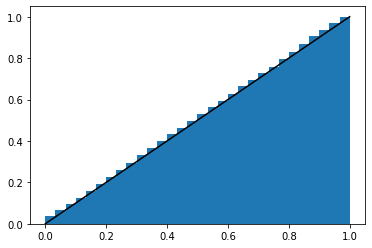

In [49]:
plt.hist(pvalues, bins=30, density=True, cumulative=True)
plt.plot([0,1], [0,1], color='k');

# Метод бакетов. Как избавиться от зависимости в данных?

Проведем модельный эксперимент. Пусть для каждого магазина мы выберем 500 пользователей для теста и контроля. Каждый из них может с определенной вероятностью прийти в какой-то из дней в магазин. Если же он пришел в магазин, то потратит там какую-то случайную сумму.

Проанализируем ежедневную выручку для 10 магазинов в пилотной и 10 магазинов в контрольной группах. Чтоб набрать объем данных для тестирования мы будем проводить эксперимент в течение 14 дней. Это принесет нам по 140 значений для пилота и для контроля.

В рамках эксперимента мы будем полагать, что каждый пришедший покупатель потратит какую-то сумму, определяемую логнормальным распределением. Для всех покупателей установим одинаковое среднее (1000) и среднеквадратичное отклонение (500). Дополнительно мы будем полагать, что каждый из покупателей приходит в магазин в среднем полтора раза в неделю.

In [ ]:
np.random.seed(0)

def get_dist_args(mean=1000, std=500):
    '''
    return: (s, scale) scale for lognorm distribution
    '''
    k = (std / mean) ** 2 + 1
    return -np.log(k / 2), mean / (k ** 0.5)

s, scale = get_dist_args(mean=1000, std=500)
dist = stats.lognorm(s=s, scale=scale)

def get_user_receipts():
    SIZE = 14
    has_visited = stats.bernoulli.rvs(p=3/14, size=SIZE)
    receipt = dist.rvs(size=SIZE)
    return receipt * has_visited

get_user_receipts()

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        , 1216.07849874,
       1342.74546857,    0.        , 2599.24530378,    0.        ,
          0.        ,  819.10019491])

На основе так сгенерированных чеков пользователя мы можем построить распределение для магазинов.
Пусть у нас как в пилотную, так и в контрольную группу попадают по 10 магазинов. В рамках модельного эксперимента сформируем UID пользователя (он нужен для воспроизводимости эксперимента)

In [ ]:
def get_store_receipts():
    SHAPE = (500, 14)
    has_visited = stats.bernoulli.rvs(p=2/7, size=SHAPE)
    receipts = dist.rvs(size=SHAPE)

    return receipts * has_visited


def get_AB_groups(exp_idx, receipts_generator=get_store_receipts):
    np.random.seed(exp_idx)
    
    group_A = [receipts_generator() for _ in range(10)]
    group_B = [receipts_generator() for _ in range(10)]
    return group_A, group_B

group_A_ind, group_B_ind = get_AB_groups(0)

Для полученных групп проведем аггрегацию и определим сумму ежедневных трат в каждом из магазинов.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


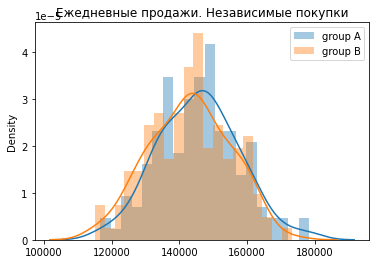

In [ ]:
def get_daily_sales(group):
    daily_sales = [store_receipts.sum(axis=0) for store_receipts in group]
    return np.concatenate(daily_sales)

def plot_daily_sales_hist(group_A, group_B, title=None):
    daily_sales_a = get_daily_sales(group_A)
    daily_sales_b = get_daily_sales(group_B)

    if title:
        plt.title(title)
    for sales, label in zip([daily_sales_a, daily_sales_b], ['A', 'B']):
        sns.distplot(sales, bins=20, label=f'group {label}')
        plt.legend()

plot_daily_sales_hist(group_A_ind, group_B_ind, 'Ежедневные продажи. Независимые покупки')

Мы помним, что перед любым экспериментом нужно провести проверку равномерности p-value в AA-тесте. Сейчас у нас как раз нет эффекта. Попробуем нарисовать график для распределения p_value

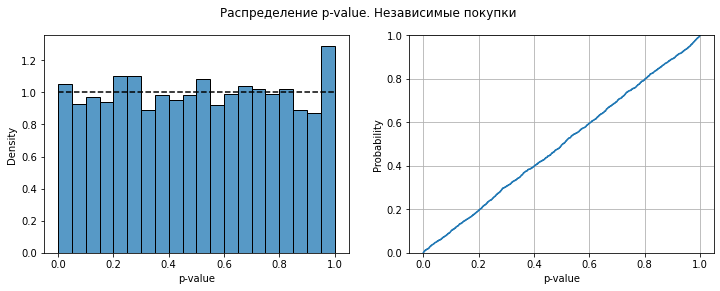

In [ ]:
# вычисляется 40 секунд
p_values = []

for exp_id in tqdm(range(2000)):
    group_A, group_B = get_AB_groups(exp_id)
    daily_sales_a = get_daily_sales(group_A)
    daily_sales_b = get_daily_sales(group_B)
    _, pvalue = stats.ttest_ind(daily_sales_a, daily_sales_b)
    p_values.append(pvalue)

plot_pvalue_ecdf(p_values, title='Распределение p-value. Независимые покупки')

Вроде бы всё хорошо.

Но давайте внимательнее посмотрим на наш модельный эксперимент.
Посмотрев внимательней, можно заметить, что в рамках эксперимента пользователи ведут себя день ото дня совершенно независимо. Действительно ли так ведут себя настоящие покупатели?

## Покупатели с любимым днём покупок

Чуть чуть поменяем поведение пользователей. Пусть пользователи так же в среднем приходят в магазин полтора раза в неделю. Но на этот раз у каждого из них будет любимый день покупок (он приходит в магазин с вероятностью 0.9), а в остальные дни приходит гораздо реже (вероятность покупки в магазине 0.1).

Изменим схему нашего эксперимента.

In [ ]:
def get_store_receipts_dependent():
    SHAPE = (500, 14)
    probs = np.ones(shape=(SHAPE[0], 7)) / 10
    days = np.random.randint(7, size=SHAPE[0])
    idx = [range(SHAPE[0]), days]
    probs[idx] = 0.9
    probs = np.concatenate([probs, probs], axis=1)
    has_visited = stats.bernoulli.rvs(p=probs)
    receipts = dist.rvs(size=SHAPE)

    return receipts * has_visited

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogra

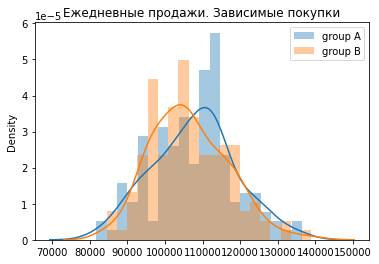

In [ ]:
group_A_dep, group_B_dep = get_AB_groups(0, receipts_generator=get_store_receipts_dependent)

plot_daily_sales_hist(group_A_dep, group_B_dep, 'Ежедневные продажи. Зависимые покупки')

Убедимся, что сами по себе метрики не изменились.

In [ ]:
print('Независимые покупки')
for group, label in zip([group_A_ind, group_B_ind], ['A', 'B']):
    print(f'group {label} : {round(np.array(group).sum())}')

print('\nЗависимые покупки')
for group, label in zip([group_A_dep, group_B_dep], ['A', 'B']):
    print(f'group {label} : {round(np.array(group).sum())}')

Независимые покупки
group A : 20383745
group B : 20026854

Зависимые покупки
group A : 15089672
group B : 14901522


Наконец, мы можем проверить распределение p_value.
Убедимся, что зависимость в данных ломает ttest.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


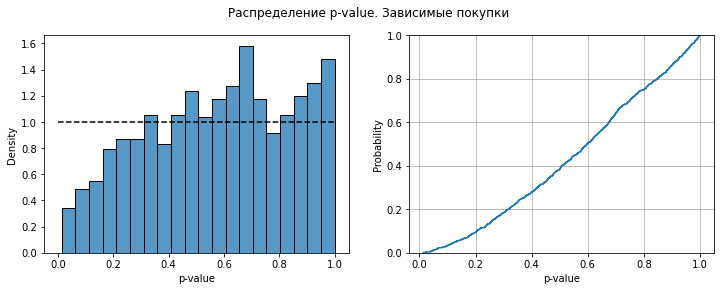

In [ ]:
# вычисляется 1 минуту
p_values = []

for exp_id in tqdm(range(2000)):
    group_A, group_B = get_AB_groups(exp_id, receipts_generator=get_store_receipts_dependent)
    daily_sales_a = get_daily_sales(group_A)
    daily_sales_b = get_daily_sales(group_B)
    _, pvalue = stats.ttest_ind(daily_sales_a, daily_sales_b)
    p_values.append(pvalue)
    
plot_pvalue_ecdf(p_values, title='Распределение p-value. Зависимые покупки')

## Метод бакетов

Мы видим, что во внешне случайный процесс очень легко проникает зависимость между данными. И это ломает наши тесты. Давайте научимся бороться с этим.

Для этого мы перейдем от подсчета суточной выручки по магазинам к подсчету общей выручки принесенной одним пользователем. Данные по пользователям мы аггрегируем в несколько бакетов. Можно выбрать 100 бакетов и произвести объединение на основе хэша. В нашей модельной задаче мы просто объединим каждого сотого пользователя из эксперимента.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


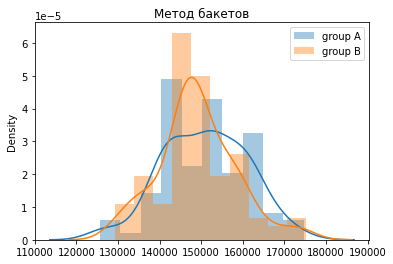

In [ ]:
# внимание! мы неявно предположили, что число покупателей 
# в каждом магазине нацело делится на число бакетов

def get_bucket_sum(group):
    B = 100
    buckets = np.zeros(shape=B)
    for store in group:
        buckets += np.array([store[idx::B, :].sum() for idx in range(B)])
    return buckets

buckets_a_dep, buckets_b_dep = get_bucket_sum(group_A_dep), get_bucket_sum(group_B_dep)

plt.title('Метод бакетов')
for sales, label in zip([buckets_a_dep, buckets_b_dep], ['A', 'B']):
    sns.distplot(sales, bins=10, label=f'group {label}')
    plt.legend()


При любом распределении чеков мы бакетное распределение стремится к нормальному. Это связано с тем, что действия отдельных пользователей можно считать независимыми.

Конечно же и это не всегда так. Муж и жена могут ходить в магазин по очереди

Убедимся, что бакетное распределение действительно даст нам равномерно распределенное p-value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


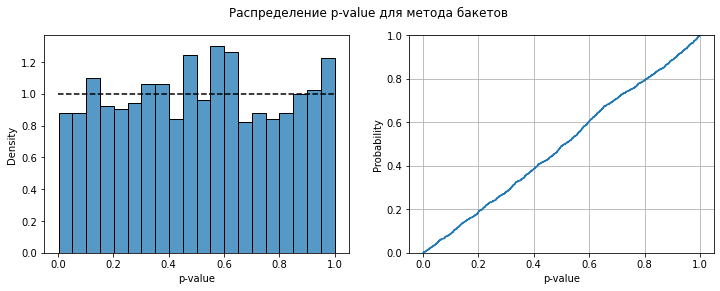

In [ ]:
#вычисляется 1:15 секунд
p_values = []

for exp_id in tqdm(range(1000)):
    group_A, group_B = get_AB_groups(exp_id, receipts_generator=get_store_receipts_dependent)
    buckets_a, buckets_b = get_bucket_sum(group_A), get_bucket_sum(group_B)
    _, pvalue = stats.ttest_ind(buckets_a, buckets_b)
    p_values.append(pvalue)
    
plot_pvalue_ecdf(p_values, title='Распределение p-value для метода бакетов')